# Tweet Classification with Classical Machine Learning

This notebook demonstrates a scalable pipeline for tweet classification using classical machine learning. The workflow covers data preprocessing, feature engineering, model selection, hyperparameter optimization, and evaluation, with a focus on reproducibility and modularity.

> **Note:** This notebook was originally developed in `project1.ipynb` and has been refactored for professinal review.

## Final Model Overview

The following cells define the model pipeline, including dataset configuration, feature engineering, preprocessing, vectorization, model training, and evaluation. All steps are modular and reproducible.

### Preparation

This section sets up the environment and defines dataset paths for modularity and reproducibility.

In [ ]:
import pandas
import numpy as np
from sklearn.model_selection import cross_val_score, PredefinedSplit
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import HashingVectorizer
import re
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from scipy.sparse import vstack,hstack
from collections import Counter
from sklearn.decomposition import PCA

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

#Paths to datasets

training_set_path = "drive/MyDrive/AI2_project1/vaccine_train_set.csv"
validation_set_path = "drive/MyDrive/AI2_project1/vaccine_validation_set.csv"

### Feature Extraction

Defines all feature engineering functions used to enrich the dataset with statistical and linguistic features, supporting improved model performance.

In [ ]:
#adds new features to given dataframe
def feature_extraction(df):
  count_chars(df)
  count_words(df)
  # count_capital_chars(df)
  # count_capital_words(df)
  # count_punctuations(df)
  # count_htags(df)
  # count_mentions(df)
  count_stopwords(df)
  count_unique_words(df)
  unique_word_freq(df)
  stop_words_freq(df)
  avg_word_length(df)
  freq_pos(df)

#all feature-extraction functions

def count_chars(df):
  df['count_chars'] = df['tweet'].apply(lambda x: len(x))

def count_words(df):
  df['count_words'] = df['tweet'].apply(lambda x: len(x.split()))

def count_capital_chars(df):
  df['count_capital_chars'] = df['tweet'].apply(lambda x: len([i for i in x if i.isupper()]))

def count_capital_words(df):
  df['count_capital_words'] = df['tweet'].apply(lambda x: sum(map(str.isupper,x.split())))

def count_punctuations(df):
  punct='!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~'
  df['count_punctuations'] = df['tweet'].apply(lambda x: len([i for i in x if i in punct]))

def count_htags(df):
  df['count_htags'] = df['tweet'].apply(lambda x: len([re.findall(r'(#[A-Za-z0-9]*)', x)]))

def count_mentions(df):
  df['count_mentions'] = df['tweet'].apply(lambda x: len([re.findall(r'(@[A-Za-z0-9]*)', x)]))

def count_stopwords(df):
  stop = set(stopwords.words('english'))
  df['count_stopwords'] = df['tweet'].apply(lambda x: len([w for w in x.split() if w in stop]))

def count_unique_words(df):
  df['count_unique_words'] = df['tweet'].apply(lambda x: len(set(x.split())))

def unique_word_freq(df):
  df['unique_word_freq'] = df['count_unique_words']/df['count_words']

def stop_words_freq(df):
  df['stop_words_freq'] = df['count_stopwords']/df['count_words']
  
def avg_word_length(df):
  df['avg_word_length'] = df['count_chars']/df['count_words']

#adds 4 new columns holding frequency of nouns, verbs, adverbs, adjectives 
def freq_pos(df):
  all_tags = ['VB','NN','JJ','RB']
  df_tags=pandas.DataFrame(np.zeros((df.shape[0],4)),columns=all_tags)
  i=0
  for tweet in df['tweet']:
    tags_int_tweet=nltk.pos_tag(tweet.split())
    tags_counter=list(zip(Counter(tag[1] for tag in tags_int_tweet).keys(),Counter(tag[1] for tag in tags_int_tweet).values()))
    for tagtype in tags_counter:
      for tag in all_tags:
        if tag in tagtype[0]:
          df_tags.loc[i,tag]=tagtype[1]/(len(tags_int_tweet)+1);
    i+=1
  for tag in all_tags:
    df[tag] = df_tags[tag]


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Data Preprocessing

In [ ]:
#transforms the data of given dataframe
def data_preprocessing(df):
  remove_links(df)
  # remove_hashtags(df)
  # remove_mentions(df)
  # remove_non_alpha(df)
  to_lowercase(df)
  lemmatize(df)
  remove_stop_words(df)

def remove_links(df):
  df.update(df.apply(lambda x: re.sub(r'(https?:\/\/[A-Za-z0-9\/.]*)|(bit.ly\/[A-Za-z0-9\/.]*)', '', x, flags=re.MULTILINE)))

def remove_non_alpha(df):
  df.update(df.apply(lambda x: re.sub(r'[^ a-zA-Z]', ' ', x, flags=re.MULTILINE)))

def to_lowercase(df):
  df.update(df.apply(lambda x: x.lower()))

def lemmatize(df):
  lemmatizer = WordNetLemmatizer() 
  df.update(df.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])))

def remove_stop_words(df):
  stop = set(stopwords.words('english'))
  df.update(df.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])))

def remove_hashtags(df):
  df.update(df.apply(lambda x: re.sub(r'(#[A-Za-z0-9]*)', '',x, flags=re.MULTILINE)))

def remove_mentions(df):
  df.update(df.apply(lambda x: re.sub(r'(@[A-Za-z0-9]*)', '',x, flags=re.MULTILINE)))

### Utilities

In [ ]:
#returns a dataframe holding precision,recall,f1,accurasy scores
#test on training and validation sets
def get_scores(trainTrue,trainPred,validationTrue,validationPred):

  scores={}
  scores['set']=[]
  scores['precision']=[]
  scores['f1']=[]
  scores['recall']=[]
  scores['accuracy']=[]

  scores['set'].append('Training')
  scores['precision'].append(metrics.precision_score(trainTrue,trainPred,average='weighted',zero_division=0))
  scores['f1'].append(metrics.f1_score(trainTrue,trainPred,average='weighted',zero_division=0))
  scores['recall'].append(metrics.recall_score(trainTrue,trainPred,average='weighted',zero_division=0))
  scores['accuracy'].append(metrics.accuracy_score(trainTrue,trainPred))

  scores['set'].append('Validation')
  scores['precision'].append(metrics.precision_score(validationTrue,validationPred,average='weighted',zero_division=0))
  scores['f1'].append(metrics.f1_score(validationTrue,validationPred,average='weighted',zero_division=0))
  scores['recall'].append(metrics.recall_score(validationTrue,validationPred,average='weighted',zero_division=0))
  scores['accuracy'].append(metrics.accuracy_score(validationTrue,validationPred))

  return  pandas.DataFrame(data=scores).set_index('set')

#fit - transform of vectorizer
def vectorize(vectorizer,data_train,data_validation):
  return pandas.DataFrame(vectorizer.fit_transform(data_train).toarray()),pandas.DataFrame(vectorizer.transform(data_validation).toarray())

#plots the learning curve
def f1_learning_curve(X_train, Y_train, X_validation, Y_validation, spots=10):

  #an array of training set sizes to be evaluated  
  ts = np.append(np.arange(0,X_train.shape[0],step=X_train.shape[0]/10,dtype=int)[1:],X_train.shape[0])

  #an array of indices that indicate training and validation set 
  test_fold = np.append(np.full(X_train.shape[0],-1),np.zeros(X_validation.shape[0]))
  ps = PredefinedSplit(test_fold).split()

  #calling lerning_curve with predifined split and train sizes
  train_sizes, train_scores, test_scores = learning_curve(
      clf, vstack((X_train,X_validation)), np.append(Y_train,Y_validation),
      cv=ps, n_jobs=-1, scoring="f1_weighted", train_sizes=ts, shuffle=True
  )
  
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  # Plot learning curve
  plt.grid()
  plt.title("Learning curve Result")
  plt.xlabel("Training size")
  plt.ylabel("f1 score")
  plt.fill_between(
      train_sizes,
      train_scores_mean - train_scores_std,
      train_scores_mean + train_scores_std,
      alpha=0.1,
      color="r",
  )
  plt.fill_between(
      train_sizes,
      test_scores_mean - test_scores_std,
      test_scores_mean + test_scores_std,
      alpha=0.1,
      color="g",
  )
  plt.plot(
      train_sizes, train_scores_mean, "o-", color="r", label="Training score"
  )
  plt.plot(
      train_sizes, test_scores_mean, "o-", color="g", label="Validation score"
  )
  plt.legend(loc="best")
  plt.show()

def display_results(X_train, Y_train, X_validation, Y_validation, Pred_train, Pred_validation):
  display(get_scores(Y_train,Pred_train,Y_validation,Pred_validation))
  f1_learning_curve(X_train, Y_train, X_validation, Y_validation);

### Pipeline Execution

Executes the end-to-end pipeline: data import, feature engineering, preprocessing, vectorization, model training, prediction, and evaluation. Results are visualized for both training and validation sets.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


,precision,f1,recall,accuracy
set,,,,
Training,0.680184,0.678775,0.692288,0.692288
Validation,0.673559,0.672845,0.686678,0.686678


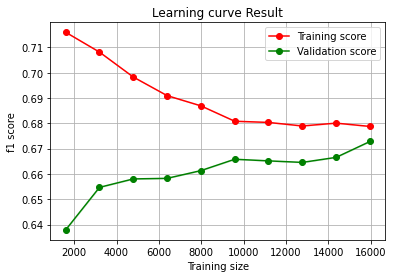

In [9]:
#importing datasets

train = pandas.read_csv(training_set_path,usecols=['tweet','label'])
validation = pandas.read_csv(validation_set_path,usecols=['tweet','label'])


#add new features based on data

feature_extraction(train)
feature_extraction(validation)


#data preprocessing

data_preprocessing(train['tweet'])
data_preprocessing(validation['tweet'])


#vectorize data

vectorizer = TfidfVectorizer(min_df=0.01,max_df=0.4,ngram_range=(1,5),max_features=1000)
X_train, X_validation = vectorize(vectorizer,train['tweet'],validation['tweet'])
Y_train, Y_validation = train['label'], validation['label']


#extracted_features holds the column-names to be merged with tf-idf array

extracted_features = list(train.columns)
extracted_features.remove('tweet')
extracted_features.remove('label')
extracted_features.remove('count_words')
extracted_features.remove('count_stopwords')
extracted_features.remove('count_unique_words')
extracted_features.remove('count_chars')


#merging tf-idf array with the new extracted features
#will raise a future warning of merging a dataframe (column index type int)
#with a dataframe (column index type str)
#That does not affect the model as the model uses only the interior of the array
X_train = pandas.merge(X_train,train[extracted_features],left_index=True, right_index=True)
X_validation = pandas.merge(X_validation,validation[extracted_features],left_index=True, right_index=True)


#initialize model and fit data

clf = LogisticRegression(multi_class='multinomial',n_jobs=-1, penalty='l2',solver='newton-cg',C=100)
clf.fit(X_train,Y_train)


#Get predictions

Pred_train = clf.predict(X_train)
Pred_validation = clf.predict(X_validation)


#display the results

display_results(X_train, Y_train, X_validation, Y_validation, Pred_train, Pred_validation)

## Additional Material for Experiments

This section documents supplementary experiments, utility functions, and supporting material used during model development. These are not part of the final production pipeline but provide valuable insights for further research or deployment.

#### Error Analysis: display_false_predictions

Outputs the tweet text, true class, and predicted class for each misclassified example, supporting detailed error analysis and model debugging.

In [ ]:
#displays the data , true and predicted class of every wrong classified tweet

def display_false_predictions(data,Y,Pred,X):
  for i in range(X.shape[0]):
    if (Y[i]!=Pred[i]):
      print('data:\n',data[i])
      # print('X:\n',X[i])
      print('True:\n',Y[i])
      print('Prediction:\n',Pred[i])

#### Different Parameter Combinations for Softmax Regression

In [ ]:
#all the combinations tried for vectorizers

vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(min_df=0.01,max_df=0.99,ngram_range=(1,5),max_features=1000,smooth_idf=True,norm='l2',sublinear_tf=True,use_idf=False)
vectorizer = TfidfVectorizer(min_df=0.01,max_df=0.4,ngram_range=(1,5),max_features=1000)
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer = TfidfVectorizer(norm='l2',use_idf=True,smooth_idf=False,sublinear_tf=True, lowercase=True)
vectorizer = CountVectorizer()
vectorizer = CountVectorizer(min_df=0.01,max_df=0.4,ngram_range=(1,5),max_features=1000)
vectorizer = CountVectorizer(lowercase=True,stop_words='english',min_df=0.2,binary=False)
vectorizer = CountVectorizer(lowercase=False,stop_words='english',binary=False)
vectorizer = CountVectorizer(lowercase=True,stop_words='english',binary=False,ngram_range=(1,2))
vectorizer = HashingVectorizer()
vectorizer = HashingVectorizer(ngram_range=(1,5))
vectorizer = HashingVectorizer(n_features=2**12)

### PCA for Dimensionality Reduction

Principal Component Analysis (PCA) was evaluated for dimensionality reduction. However, it led to reduced performance and was not included in the final pipeline.

In [ ]:
#dimensionality reduction (having bad metric results)


pca = PCA(n_components=100)
X_train = pandas.DataFrame(pca.fit_transform(X_train))
X_validation = pandas.DataFrame(pca.fit_transform(X_validation))

#### GridSearchCV

Used to find the optimal parameters for softmax regression.

The final parameters are:

**C**: 100

**penalty**: l2

**solver**: newton-cg

In [ ]:
# GridSearchCV indicated best results
#C: 100 -  penalty: l2 - solver: newton-cg 

from sklearn.model_selection import GridSearchCV
model = LogisticRegression(multi_class='multinomial',n_jobs=-1)
ts = np.append(np.arange(0,X_train.shape[0],step=X_train.shape[0]/10,dtype=int)[1:],X_train.shape[0])
test_fold = np.append(np.full(X_train.shape[0],-1),np.zeros(X_validation.shape[0]))
ps = PredefinedSplit(test_fold).split()
space = [
         {
             'penalty':['l2','none'],
          'solver':['lbfgs','newton-cg','saga','sag'],
          'C':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
          },
         {
             'penalty':['l1','none'],
          'solver':['saga'],
          'C':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
          },
         {
             'penalty':['elasticnet','none'],
          'l1_ratio':[0.5],
          'solver':['saga'],
          'C':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
          }
]
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=ps)
result = search.fit(vstack((X_train,X_validation)),np.append(Y_train,Y_validation))
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

#### Different Combinations of Parameters for Softmax Regression

In [ ]:
#all different combinations for parameter tuning tried on softmax regression

clf = LogisticRegression(multi_class='multinomial',n_jobs=-1,C=result.best_params_['C'],
                         class_weight=result.best_params_['class_weight'],
                         penalty=result.best_params_['penalty='],solver=result.best_params_['solver'])
clf = LogisticRegression(multi_class='multinomial',n_jobs=-1,max_iter=100,class_weight='balanced')
clf = LogisticRegression(multi_class='multinomial',n_jobs=-1,max_iter=100)


display_false_predictions(train['tweet'],train['label'],Pred_train,X_train)
print('--------------------------------------------------------')
display_false_predictions(validation['tweet'],validation['label'],Pred_validation,X_validation)